In [1]:
# imports
import os
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from ml4cc.models import LSTM
from ml4cc.tools.evaluation import peakFinding as pf
from ml4cc.data.FCC import dataloader as fdl
from ml4cc.data.CEPC import dataloader as cdl

/opt/conda/lib/python3.11/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/opt/conda/lib/python3.11/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [2]:
with initialize(version_base=None, config_path="../config", job_name="test_app"):
    cfg = compose(config_name="training")

In [ ]:
# FCC eval:
FCC_RESULT_OUTPUT_DIR = "/home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/"
os.makedirs(FCC_RESULT_OUTPUT_DIR, exist_ok=True)
FCC_BEST_MODEL_PATH = "/home/laurits/ml4cc/training-outputs/20250103_FCC_350_epoch/models/peakFinding-epoch=218-val_loss=0.02.ckpt"
FCC_METRICS_PATH = "/home/laurits/ml4cc/training-outputs/20250103_FCC_350_epoch/logs/peakFinding/version_0/metrics.csv"

model = LSTM.LSTMModule.load_from_checkpoint(FCC_BEST_MODEL_PATH, weights_only=True)
model.eval()

FCC_ENERGIES = [2, 4, 6, 8, 10, 165, 180]
FCC_BASE_TEST_DIR = "/scratch/persistent/laurits/ml4cc/FCC/preprocessed_data/test/"

for energy in FCC_ENERGIES:
    data_path = os.path.join(FCC_BASE_TEST_DIR, f"{energy}_1.parquet")
    test_dataset = fdl.IterableFCCDataset(
        data_path=data_path,
        cfg=cfg,
        dataset_type="test",
    )
    output_dir = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy))
    os.makedirs(output_dir, exist_ok=True)
    test_loader = DataLoader(test_dataset, batch_size=80)
    pf.evaluate_training(
        model=model,
        dataloader=test_loader,
        metrics_path=FCC_METRICS_PATH,
        cfg=cfg,
        output_dir=output_dir
    )

In [3]:
import awkward as ak
import matplotlib
import boost_histogram as bh
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep

In [4]:
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

def plot_histograms(num_true_peaks, num_pred_peaks, output_path):
    bins = np.linspace(0, 40, 20)
    plt.hist(num_true_peaks, bins=bins, histtype='step', hatch='//', label='true')
    plt.hist(num_pred_peaks, bins=bins, histtype='step', hatch='\\', label='pred')
    plt.legend()
    plt.grid()
    plt.ylabel('Number entrier / bin')
    plt.xlabel('Number peaks')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close('all')

def plot_ratios(ratios, output_path):
    bins = np.linspace(0.5, 1.5, 15)
    hep.histplot(to_bh(ratios, bins=bins), density=True)
    plt.grid()
    plt.ylabel('Number entrier / bin')
    plt.xlabel('#predicted peaks / #generated peaks')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close('all')

In [ ]:
# Count the number of true and detected primary clusters after the peak finding
for energy in FCC_ENERGIES:
    pred_path = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy), "predictions.parquet")
    data = ak.from_parquet(pred_path)
    pred = data.detected_peaks
    true = data.target
    num_true_peaks = ak.sum(true == 1, axis=-1)
    num_pred_peaks = ak.sum(pred == 1, axis=-1)
    ratios = num_pred_peaks / num_true_peaks
    histo_output_path = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy), "pred_true_distributions.png")
    plot_histograms(num_true_peaks, num_pred_peaks, histo_output_path)
    ratio_output_path = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy), "pred_true_ratio_distribution.png")
    plot_ratios(ratios, ratio_output_path)

In [ ]:
results_auc = {
    2: 0.9876,
    4: 0.9889,
    6: 0.9886,
    8: 0.9891,
    10: 0.9890,
    165: 0.9889,
    180: 0.9888
}


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.styles.CMS)

def plot_performances(performances: dict, mean: int = None):
    if mean is None:
        mean = np.mean(list(performances.values()))
    fig, ax = plt.subplots()
    labels = [f"{i} GeV" for i in list(performances.keys())]
    x_values = np.arange(len(performances.values()))
    auc_values = np.array(list(performances.values()))

    ax.set_xticks(np.arange(len(performances.values())))
    ax.set_xticklabels(labels)
    plt.xticks(rotation=90)
    
    lower_than_average_mask = auc_values < mean
    for value, loc in zip(auc_values[lower_than_average_mask], x_values[lower_than_average_mask]):
        plt.vlines(loc, ymin=value, ymax=mean, color='red', ls='--')
    for value, loc in zip(auc_values[~lower_than_average_mask], x_values[~lower_than_average_mask]):
        plt.vlines(loc, ymin=mean, ymax=value, color='green', ls='--')
    plt.scatter(x_values[lower_than_average_mask], auc_values[lower_than_average_mask], color='red', s=80)
    plt.scatter(x_values[~lower_than_average_mask], auc_values[~lower_than_average_mask], color='green', s=80)
    plt.axhline(mean, xmin=0, xmax=len(results_auc.values()), ls='--', color='k')

In [ ]:
plot_performances(results_auc)

In [ ]:
# Evaluate best model before training end
test_data_path = os.path.join(FCC_BASE_TEST_DIR, "*")
full_test_dataset = fdl.IterableFCCDataset(
    data_path=test_data_path,
    cfg=cfg,
    dataset_type="test",
)
os.makedirs('/home/laurits/tmp/full_test_eval', exist_ok=True)
full_test_loader = DataLoader(full_test_dataset, batch_size=80)
pf.evaluate_training(
    model=model,
    dataloader=full_test_loader,
    metrics_path=FCC_METRICS_PATH,
    cfg=cfg,
    output_dir='/home/laurits/tmp/full_test_eval'
)

In [ ]:
# Load predictions
full_test_pred_data = ak.from_parquet("/home/laurits/tmp/full_test_eval/predictions.parquet")
predicted_peak_count = ak.sum(full_test_pred_data.detected_peaks == 1, axis=-1)
true_peak_count = ak.sum(full_test_pred_data.target == 1, axis=-1)

In [ ]:
bins = np.linspace(0, 25, num=25)
plt.hist(predicted_peak_count, bins=bins, histtype='step', label="Pred count")
plt.hist(true_peak_count, bins=bins, histtype='step', label="True count")
plt.legend()
plt.xlabel("Number of primary peaks")
plt.ylabel("Count /bin")
plt.grid()

In [ ]:
# Calculate resolutions
ratios = predicted_peak_count / true_peak_count

ratio_bins = np.linspace(0.5, 1.5, num=16)
n = plt.hist(ratios, bins=ratio_bins, density=True, histtype='step')[0]
plt.xlabel("#predicted / #true")
plt.ylabel("Count /bin")
plt.grid()

In [12]:
def IQR(ratios: np.array) -> np.array:
    return np.quantile(ratios, 0.75) - np.quantile(ratios, 0.25)

In [ ]:
median = np.median(ratios)
IQR_ = IQR(ratios)
weighted_IQR = IQR_ / median

print(f"IQR: {IQR_:.3f} \t Median: {median:.3f} \t Resolution: {weighted_IQR:.3f}")

In [6]:
# # CEPC eval:
CEPC_RESULT_OUTPUT_DIR = "/home/laurits/tmp/20250117_CEPC_peakFinding/"
os.makedirs(CEPC_RESULT_OUTPUT_DIR, exist_ok=True)
CEPC_BEST_MODEL_PATH = "/home/laurits/ml4cc/training-outputs/20250109_CEPC_150_epoch/models/peakFinding-epoch=76-val_loss=0.02.ckpt"
CEPC_METRICS_PATH = "/home/laurits/ml4cc/training-outputs/20250109_CEPC_150_epoch/logs/peakFinding/version_0/metrics.csv"

model = LSTM.LSTMModule.load_from_checkpoint(CEPC_BEST_MODEL_PATH, weights_only=True)
model.eval()

CEPC_BASE_TEST_DIR = "/scratch/persistent/laurits/ml4cc/CEPC/preprocessed_data/peakFinding/test/"

data_path = os.path.join(CEPC_BASE_TEST_DIR, "*")
dataset = cdl.CEPCDataset(data_path=data_path)
test_dataset = cdl.IterableCEPCDataset(
    dataset=dataset,
    cfg=cfg,
    dataset_type="test",
)
test_loader = DataLoader(test_dataset, batch_size=200)
pf.evaluate_training(
    model=model,
    dataloader=test_loader,
    metrics_path=CEPC_METRICS_PATH,
    cfg=cfg,
    output_dir=CEPC_RESULT_OUTPUT_DIR
)

There are 500,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [6:02:08<00:00, 23.01it/s]


Saving 500000 processed entries to /home/laurits/tmp/20250117_CEPC_peakFinding/predictions.parquet


In [7]:
cepc_pred_path = os.path.join(CEPC_RESULT_OUTPUT_DIR, "predictions.parquet")
cepc_data = ak.from_parquet(cepc_pred_path)
cepc_pred = cepc_data.detected_peaks
cepc_true = cepc_data.target
cepc_true_peaks = ak.sum(cepc_true == 1, axis=-1)
cepc_num_pred_peaks = ak.sum(cepc_pred == 1, axis=-1)
cepc_ratios = cepc_num_pred_peaks / cepc_true_peaks
cepc_histo_output_path = os.path.join(CEPC_RESULT_OUTPUT_DIR, "true_pred_distributions.png")
plot_histograms(cepc_true_peaks, cepc_num_pred_peaks, cepc_histo_output_path)
ratio_output_path = os.path.join(CEPC_RESULT_OUTPUT_DIR, "true_pred_ratio_distribution.png")
plot_ratios(cepc_ratios, ratio_output_path)

In [8]:
# Load predictions
cepc_full_test_pred_data = ak.from_parquet("/home/laurits/tmp/20250113_CEPC_peakFinding/predictions.parquet")
cepc_predicted_peak_count = ak.sum(cepc_full_test_pred_data.detected_peaks == 1, axis=-1)
cepc_true_peak_count = ak.sum(cepc_full_test_pred_data.target == 1, axis=-1)

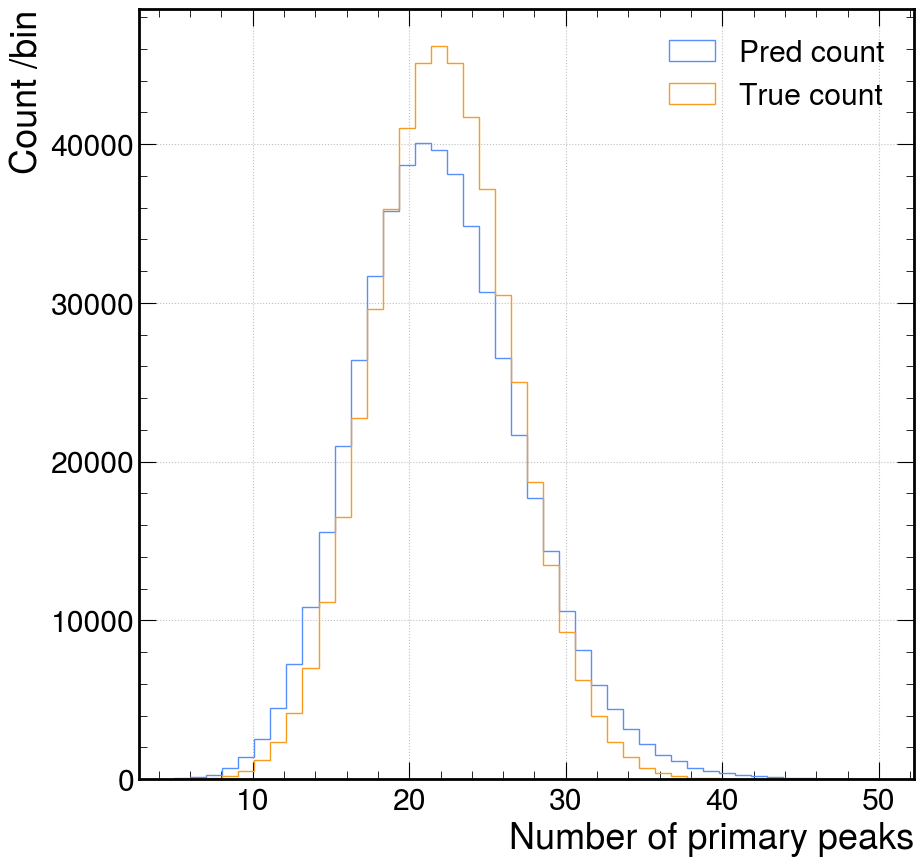

In [9]:
bins = np.linspace(5, 50, num=45)
plt.hist(cepc_predicted_peak_count, bins=bins, histtype='step', label="Pred count")
plt.hist(cepc_true_peak_count, bins=bins, histtype='step', label="True count")
plt.legend()
plt.xlabel("Number of primary peaks")
plt.ylabel("Count /bin")
plt.grid()

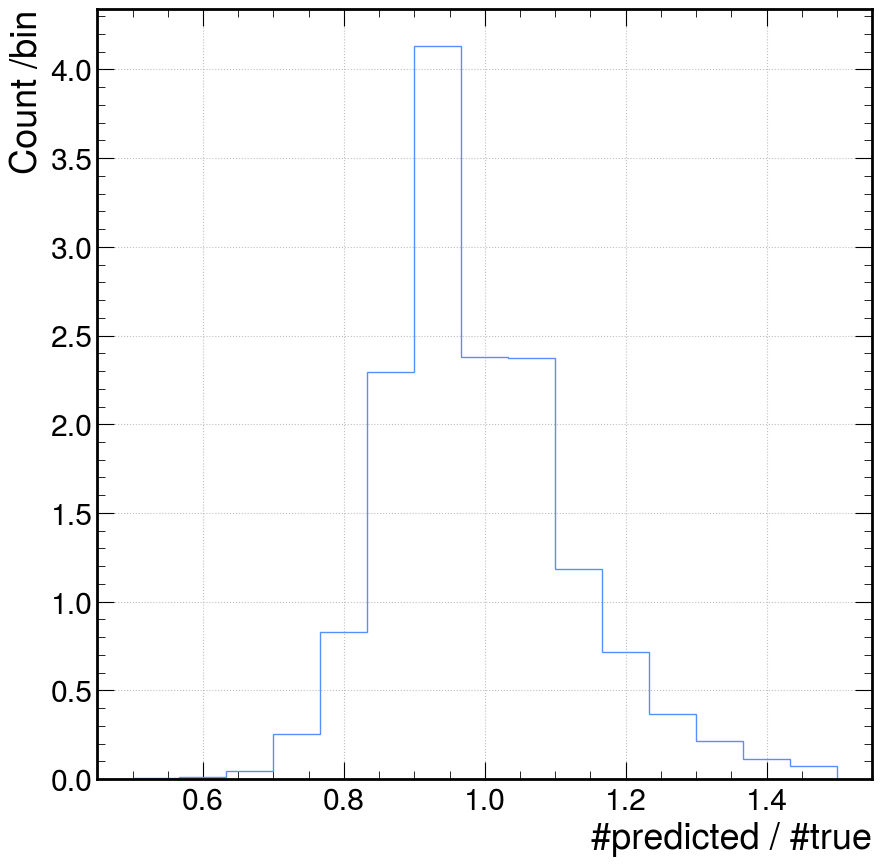

In [10]:
# Calculate resolutions
cepc_ratios = cepc_predicted_peak_count / cepc_true_peak_count

ratio_bins = np.linspace(0.5, 1.5, num=16)
n = plt.hist(cepc_ratios, bins=ratio_bins, histtype='step', density=True)[0]
plt.xlabel("#predicted / #true")
plt.ylabel("Count /bin")
plt.grid()

In [13]:
cepc_median = np.median(cepc_ratios)
cepc_IQR_ = IQR(cepc_ratios)
cepc_weighted_IQR = cepc_IQR_ / cepc_median

print(f"IQR: {cepc_IQR_:.3f} \t Median: {cepc_median:.3f} \t Resolution: {cepc_weighted_IQR:.3f}")

IQR: 0.151 	 Median: 0.966 	 Resolution: 0.156


In [ ]:
from ml4cc.tools.visualization.waveform import plot_waveform
from ml4cc.tools.data import io

In [ ]:
root_data = io.load_root_file("/scratch/persistent/laurits/ml4cc/CEPC/data/peakFinding/train/signal_noise05_PFtrain_0.root")
data = ak.from_parquet('/home/laurits/ml4cc/training-outputs/20250103_FCC_350_epoch/predictions.parquet')

In [ ]:
i=2
pred = data.detected_peaks[i]
target = data.target[i]
wf = data.waveform[i]
x_peaks_true = np.arange(len(target))[target == 1]
x_peaks_pred = np.arange(len(pred))[target == 1]

In [ ]:
fig, ax = plot_waveform(wf)
for i, peak in enumerate(x_peaks_true):
    if i == 0:
        label = "True peak"
    else:
        label = ""
    ax.axvline(peak, ls="-", color='k', label=label)
for i, peak in enumerate(x_peaks_pred):
    if i == 0:
        label = 'Pred peak'
    else:
        label = ""
    ax.axvline(peak, ls="--", color='r', label=label)
plt.legend()

In [ ]:
root_data.fields

In [ ]:
wf_i = root_data.wf_i[0]
tag = root_data.tag[0]

In [ ]:
tag[tag == 2]

In [ ]:
plot_waveform(wf_i)